# SI630 Project: Toxic Spans Detection

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import random
random.seed(2021)
np.random.seed(2021)
from preprocess import load_raw, load_data

In [2]:
# !git clone https://github.com/ipavlopoulos/toxic_spans.git
from toxic_spans.evaluation.semeval2021 import f1

**Reference: Two of the baselines (random and spacy tagging) and data used below are provided by John Pavlopoulos, Ion Androutsopoulos, Jeffrey Sorensen and Léo Laugier at https://github.com/ipavlopoulos/toxic_spans. The offensive word list baseline uses the word list from https://github.com/RobertJGabriel/Google-profanity-words**

## EDA

In [3]:
train, trial, test = load_raw()

In [4]:
train.isnull().sum()

spans    0
text     0
dtype: int64

In [5]:
trial.isnull().sum()

spans    0
text     0
dtype: int64

In [6]:
test.isnull().sum()

spans    0
text     0
dtype: int64

In [7]:
train['span_len'] = train['spans'].apply(lambda x: len(x))
train['text_len'] = train['text'].apply(lambda x: len(x))
train['toxic_ratio'] = train['span_len'] / train['text_len']
train.head()

,spans,text,span_len,text_len,toxic_ratio
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...,32,98,0.326531
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio...",7,695,0.010072
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed.",4,33,0.121212
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...,11,69,0.159420
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA...",7,960,0.007292


In [8]:
train['toxic_ratio'].median()

0.06862745098039216

In [9]:
trial['span_len'] = trial['spans'].apply(lambda x: len(x))
trial['text_len'] = trial['text'].apply(lambda x: len(x))
trial['toxic_ratio'] = trial['span_len'] / train['text_len']
trial.head()

,spans,text,span_len,text_len,toxic_ratio
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...,10,74,0.102041
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...,6,140,0.008633
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th...",6,188,0.181818
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...,6,108,0.086957
4,[],As long as your willing to pay a lot more for ...,0,208,0.000000


In [10]:
trial.toxic_ratio.median()

0.06528843421426542

In [11]:
test['span_len'] = test['spans'].apply(lambda x: len(x))
test['text_len'] = test['text'].apply(lambda x: len(x))
test['toxic_ratio'] = test['span_len'] / test['text_len']
test.head()

,spans,text,span_len,text_len,toxic_ratio
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",That's right. They are not normal. And I am st...,22,156,0.141026
1,"[81, 82, 83, 84, 85, 86]","""Watch people die from taking away their healt...",6,110,0.054545
2,[],tens years ago i contacted the PDR and suggest...,0,500,0.000000
3,[],The parallels between the ANC and the Sicilian...,0,529,0.000000
4,[],Intel Community: ‘How can we work for a Presid...,0,671,0.000000


In [12]:
test.toxic_ratio.median()

0.04427579253948695

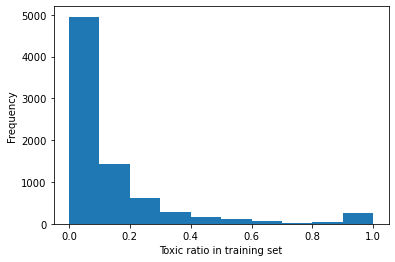

In [13]:
ax = train.toxic_ratio.plot(kind='hist')
ax.set_xlabel('Toxic ratio in training set')
ax.get_figure().savefig("train_toxic_ratio.png", dpi=400)

In [14]:
len(train[train.toxic_ratio > 0.45])/len(train)

0.06915228618213881

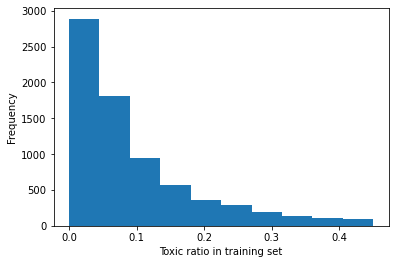

In [15]:
ax = train.toxic_ratio.plot(kind='hist', range=[0,0.45])
ax.set_xlabel('Toxic ratio in training set')
ax.get_figure().savefig('train_toxic_ratio_scaled.png', dpi=400)

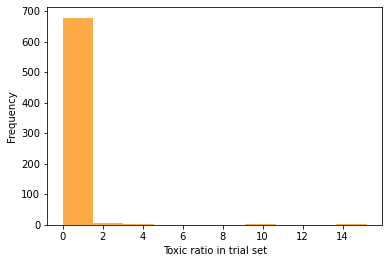

In [16]:
ax = trial.toxic_ratio.plot(kind='hist', color='#fdaa48')
ax.set_xlabel('Toxic ratio in trial set')
ax.get_figure().savefig("trial_toxic_ratio.png", dpi=400)

In [17]:
len(train[train.toxic_ratio > 0.5])/len(train)

0.06146869882856783

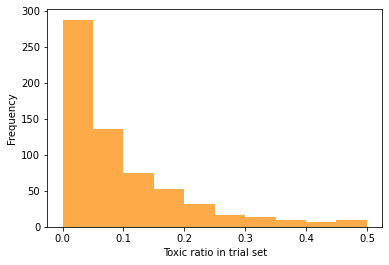

In [18]:
ax = trial.toxic_ratio.plot(kind='hist', range=[0, 0.5], color='#fdaa48')
ax.set_xlabel('Toxic ratio in trial set')
ax.get_figure().savefig("trial_toxic_ratio_scaled.png", dpi=400)

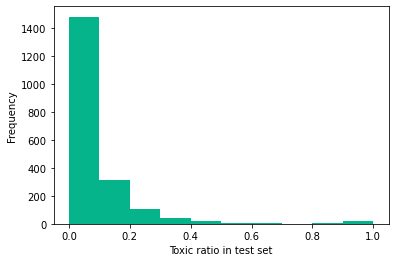

In [19]:
ax = test.toxic_ratio.plot(kind='hist', color='#06b48b')
ax.set_xlabel('Toxic ratio in test set')
ax.get_figure().savefig('test_toxic_ratio.png', dpi=400)

In [20]:
len(test[test.toxic_ratio > 0.3])/len(test)

0.051

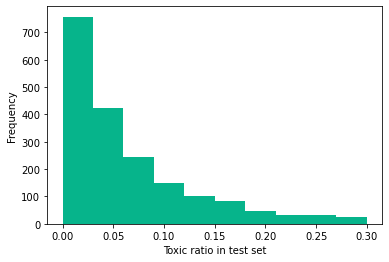

In [21]:
ax = test.toxic_ratio.plot(kind='hist', range=[0, 0.3], color='#06b48b')
ax.set_xlabel('Toxic ratio in test set')
ax.get_figure().savefig('test_toxic_ratio_scaled.png', dpi=400)

## Preprocessing and hyperparameter optimization

In the following sections, I would use the data processed by `preprocess.py`.

In [22]:
train_df, trial_df, test = load_data()

## Training my best model

In [23]:
import logging
from simpletransformers.ner import NERModel, NERArgs
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

model_args = NERArgs()
model_args.labels_list = ["T", "N"]
model_args.overwrite_output_dir = True
model_args.reprocess_input_data = True
model_args.output_dir = "./output-ner"
model_args.train_batch_size = 4
model_args.eval_batch_size = 16
model_args.adam_epsilon = 1e-9
model_args.mlm = True
model_args.manual_seed = 2021  # reproductivity
model_args.num_train_epochs = 50
model_args.learning_rate = 3e-7
model_args.no_cache = True
model_args.no_save = True

model = NERModel("roberta", "roberta-base", use_cuda=True, args=model_args)
model.train_model(train_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

/home/cyuntao/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

INFO:simpletransformers.ner.ner_model: Training of roberta model complete. Saved to ./output-ner.


(99250, 0.25173676223929514)

In [24]:
result, model_outputs, predictions = model.eval_model(train_df)
print(result)

INFO:simpletransformers.ner.ner_model: Converting to features started.


/home/cyuntao/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: N seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/cyuntao/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: T seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/cyuntao/.local/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyuntao/.local/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyuntao/.local/lib/python3.8/site-packages/seqeval/m

{'eval_loss': 0.2316587519507773, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}


In [25]:
result, model_outputs, predictions = model.eval_model(trial_df)
print(result)

INFO:simpletransformers.ner.ner_model: Converting to features started.


INFO:simpletransformers.ner.ner_model:{'eval_loss': 0.21407424099743366, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}


{'eval_loss': 0.21407424099743366, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}


## Predicting, Postprocessing and Evaluating

In [26]:
predictions, raw_outputs = model.predict(list(test.text_punc_strip))

INFO:simpletransformers.ner.ner_model: Converting to features started.


In [27]:
def word2offset(words, text):
    offset_list = []
    for each in words:
        for m in re.finditer(r'\b({})\b'.format(re.escape(each)), text):
            offset_list += list(range(m.start(), m.start()+len(each)))
    return sorted(set(offset_list))

In [28]:
'''
toxic_predictions = []
for i, row in test.iterrows():
    toxic_list = []
    for each in predictions[i]:
        key = list(each.keys())[0]
        if each[key] == 'T':
            j = row.text.index(key)
            toxic_list += list(range(row.index_list[j], row.index_list[j]+len(word)))
    toxic_predictions.append(toxic_list)
'''
toxic_predictions = []
for i, row in test.iterrows():
    toxic_list = []
    for each in predictions[i]:
        key = list(each.keys())[0]
        if each[key] == 'T':
            toxic_list.append(key)
    toxic_predictions.append(word2offset(toxic_list, row.text))

In [29]:
test['predictions'] = toxic_predictions
test['f1'] = test.apply(lambda row: f1(row.predictions, row.spans), axis=1)

In [30]:
# offensive list baseline
'''
for i, row in test.iterrows():
    toxic_list = []
    for j, word in enumerate(row.text):
        if word.lower() in toxic_words:
            toxic_list += list(range(row.index_list[j], row.index_list[j]+len(word)))
    offensive_list_pred.append(toxic_list)
'''
with open("list.txt", "r") as f:
    toxic_words = f.read().splitlines()
offensive_list_pred = []
for i, row in test.iterrows():
    toxic_list = []
    words = row.text_punc_strip.split()
    for word in words:
        if word.lower() in toxic_words:
            toxic_list.append(word)
    offensive_list_pred.append(word2offset(toxic_list, row.text))

In [31]:
random_baseline = lambda text: [i for i, char in enumerate(text) if random.random()>0.5]
test['random_predictions'] = test.text.apply(random_baseline)
test['random_f1'] = test.apply(lambda row: f1(row.random_predictions, row.spans), axis=1)
test['offsenive_list_predictions'] = offensive_list_pred
test['offensive_list_f1'] = test.apply(lambda row: f1(row.offsenive_list_predictions, row.spans), axis=1)
test['spacy_f1'] = pd.read_csv('spacy_f1.csv')['spacy_f1']

In [32]:
from scipy.stats import sem
print(f"Random baseline F1 = {test.random_f1.mean():.3f} ± {sem(test.random_f1):.3f}")
print(f"Offensive word list baseline F1 = {test.offensive_list_f1.mean():.3f} ± {sem(test.offensive_list_f1):.3f}")
print(f"Spacy tagging baseline F1 = {test.spacy_f1.mean():.3f} ± {sem(test.spacy_f1):.3f}")
print(f"My model F1 = {test.f1.mean():.3f} ± {sem(test.f1):.3f}")

Random baseline F1 = 0.121 ± 0.003
Offensive word list baseline F1 = 0.236 ± 0.009
Spacy tagging baseline F1 = 0.659 ± 0.010
My model F1 = 0.661 ± 0.009


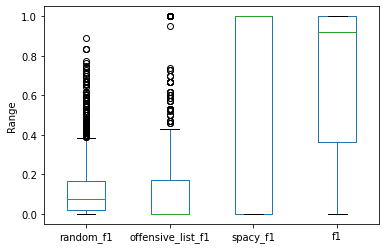

In [33]:
ax = test[['random_f1','offensive_list_f1', 'spacy_f1', 'f1']].plot(kind='box')
ax.set_ylabel('Range')
ax.get_figure().savefig('f1_figure.png', dpi=400)